# Dropout

Az úgynevezett dropout , magában foglalja a zaj injektálását az egyes belső rétegek kiszámítása során az előrehaladás során, és ez a neurális hálózatok betanításának szabványos technikájává vált. <br>
A módszert dropoutnak nevezik , mert egyes neuronokat szó szerint kiejtünk tanitas közben. A tanitass során, minden iterációnál a standard dropout abból áll, hogy minden rétegben nullázzuk a csomópontok egy részét a következő réteg kiszámítása előtt. A droptout felbontja a koadaptaciot es egy zaj bekuldesevel valosul meg.

### Simple example of dropout in Flux

In [1]:
import Flux,Plots,Statistics

In [2]:
using Flux,Statistics
model = Chain(Dense(ones(3,2)), Dropout(0.4))

Chain(
  Dense(2 => 3),                        # 9 parameters
  Dropout(0.4),
) 

In [3]:
# Dropout does not have effect in the test mode
model(ones(2, 7))  

3×7 Matrix{Float64}:
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0
 2.0  2.0  2.0  2.0  2.0  2.0  2.0

Dropout does not have effect in the test mode, but after training we can see that some nodes are 0.


In [4]:
Flux.trainmode!(model);  
model(ones(2, 7))

3×7 Matrix{Float64}:
 3.33333  0.0      3.33333  0.0      3.33333  3.33333  3.33333
 3.33333  3.33333  3.33333  3.33333  3.33333  3.33333  3.33333
 0.0      3.33333  3.33333  3.33333  3.33333  3.33333  0.0

In [5]:
y = model(ones(2, 10_000));

In [6]:
using Statistics
# The dropout does not make a big change on the mean
print(mean(y))  


1.997222222222221

### Using dropout in the previous MNIST problem 

In [7]:
using Flux
model = Chain(
  Dense(28*28,200, relu),Dropout(0.5),
  Dense(200,200,relu),Dropout(0.5),
  Dense(200, 10),
  softmax)

Chain(
  Dense(784 => 200, relu),              # 157_000 parameters
  Dropout(0.5),
  Dense(200 => 200, relu),              # 40_200 parameters
  Dropout(0.5),
  Dense(200 => 10),                     # 2_010 parameters
  NNlib.softmax,
)                   # Total: 6 arrays, 199_210 parameters, 778.602 KiB.

In [8]:
using MLDatasets

# load training set
train_x, train_y = MNIST.traindata();

# load test set
test_x,  test_y  = MNIST.testdata();

┌ Warning: MNIST.traindata() is deprecated, use `MNIST(split=:train)[:]` instead.
└ @ MLDatasets C:\Users\Szasz\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:187
┌ Warning: MNIST.testdata() is deprecated, use `MNIST(split=:test)[:]` instead.
└ @ MLDatasets C:\Users\Szasz\.julia\packages\MLDatasets\bg0uc\src\datasets\vision\mnist.jl:195


In [9]:
x_train = Float32.(train_x)
y_train = Flux.onehotbatch(train_y, 0:9);

x_test = Float32.(test_x)
y_test = Flux.onehotbatch(test_y, 0:9);

loss(X, y) = Flux.crossentropy(model(X), y)
opt = Flux.ADAM();

In [10]:
using Statistics

function calculate_accuracy_test()
    test_data = [(Flux.flatten(x_test), test_y)]
    accuracy = 0
    err=0;
    nr_of_errors=0
    for i in 1:length(test_y)
        if findmax(model(test_data[1][1][:, i]))[2] - 1  == test_y[i]
            accuracy = accuracy + 1
        else
            nr_of_errors=nr_of_errors+1
            A=abs.(model(test_data[1][1][:, i]) .- y_test[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end
    
    m = accuracy / length(test_y)
    n = err/ length(test_y)
    s = nr_of_errors 
    println("The val_accuracy is: ",m)
    println("Mean absolute error (TEST): ",n)
    println("Number of errors: ",s)
    return m,n,s
end;

In [11]:
#with this function we'll calculate the accuracy in every epoch
using Statistics

function calculate_accuracy_train()
    train_data = [(Flux.flatten(x_train), train_y)]
    err=0;
    for i in 1:length(train_y)
        if findmax(model(train_data[1][1][:, i]))[2] - 1  != train_y[i]
            A=abs.(model(train_data[1][1][:, i]) .- y_train[:,i])
            aux=0
            for a in A
                aux=aux+a
            end
            err=err+aux;
        end
    end    
    n = err/ length(train_y)
    println("Mean absolute error (TRAIN): ",n)
    return n
end;

In [12]:
using Flux

parameters = Flux.params(model)
# flatten() function converts array 28x28x60000 into 784x60000 
train_data = [(Flux.flatten(x_train), Flux.flatten(y_train))]

val_acc=zeros(0)
mean_err_test=zeros(0)
nr_err=zeros(0)
mean_err_train=zeros(0)
nr_of_epoch=40

for i in 1:nr_of_epoch
    println("epoch ",i)
    Flux.train!(loss, parameters, train_data, opt)
    
    n = calculate_accuracy_train()
    append!(mean_err_train,n)
    m, n, s = calculate_accuracy_test()
    append!( val_acc, m )
    append!( mean_err_test, n )
    append!( nr_err, s )
    
end

epoch 1
Mean absolute error (TRAIN): 1.3983699
The val_accuracy is: 0.2179
Mean absolute error (TEST): 1.4031808
Number of errors: 7821
epoch 2
Mean absolute error (TRAIN): 1.0354358
The val_accuracy is: 0.4257
Mean absolute error (TEST): 1.0245193
Number of errors: 5743
epoch 3
Mean absolute error (TRAIN): 0.77413535
The val_accuracy is: 0.5756
Mean absolute error (TEST): 0.7531424
Number of errors: 4244
epoch 4
Mean absolute error (TRAIN): 0.62429243
The val_accuracy is: 0.6582
Mean absolute error (TEST): 0.60352147
Number of errors: 3418
epoch 5
Mean absolute error (TRAIN): 0.537854
The val_accuracy is: 0.7091
Mean absolute error (TEST): 0.51101977
Number of errors: 2909
epoch 6
Mean absolute error (TRAIN): 0.48766252
The val_accuracy is: 0.737
Mean absolute error (TEST): 0.45912045
Number of errors: 2630
epoch 7
Mean absolute error (TRAIN): 0.45307136
The val_accuracy is: 0.7522
Mean absolute error (TEST): 0.4289999
Number of errors: 2478
epoch 8
Mean absolute error (TRAIN): 0.4315

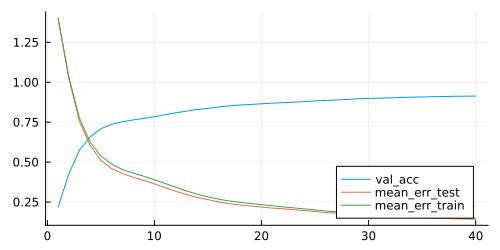

In [13]:
x = range(1, nr_of_epoch, step=1)

p= Plots.plot(x,val_acc,label="val_acc",legend=:bottomright, size=(500, 250))
p= Plots.plot!(p,x,mean_err_test,label="mean_err_test")
p= Plots.plot!(p,x,mean_err_train,label="mean_err_train")